In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian Mixture Model for IPOC data - 2nd try

In [15]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [12]:
for e in db.get_all_collections():
    if 'IPOC.AB1' in e:
        print(e)
        
df = db.query("^.*IPOC.AB1.*")
display(df.describe())

MKI.UA23.IPOC.AB1:T_LENGTH
MKI.UA23.IPOC.AB1:E_KICK
MKI.UA23.IPOC.AB1:T_FALLTIME
MKI.UA23.IPOC.AB1:T_START_TH
MKI.UA23.IPOC.AB1:T_RISETIME
MKI.UA23.IPOC.AB1:I_STRENGTH
MKI.UA23.IPOC.AB1:T_DELAY
Fetching data for pattern ^.*IPOC.AB1.* from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:E_KICK
Fetching data for MKI.UA23.IPOC.AB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.AB1:T_START_TH
Fetching data for MKI.UA23.IPOC.AB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.AB1:I_STRENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_DELAY


MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                46090.000000              46090.000000   
mean                     4.319727               3685.279259   
std                     10.622216               2893.033278   
min                      0.000000                400.200000   
25%                      2.080300                450.000000   
50%                      2.085100               3565.920000   
75%                      4.484500               6499.440000   
max                    139.371000               7864.200000   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                  46090.000000                  46090.000000   
mean                       1.389165                     53.097154   
std                        1.918227                      6.555854   
min                     -125.379000                    -13.831000   
25%                        1.390000                     52.286000   
50%                        1.393700                     52.288000   
75%                        1.400500                     52.291000   
max                      125.457900                     62.789000   

       MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                  46090.000000                  46090.000000   
mean                       0.654392                      4.612804   
std                        0.121501                      0.772884   
min                      -13.608500                     -0.000600   
25%                        0.657300                      4.647100   
50%                        0.657800                      4.833500   
75%                        0.662200                      5.074600   
max                       13.687100                      5.193200   

       MKI.UA23.IPOC.AB1:T_DELAY  
count               46090.000000  
mean                   53.751547  
std                     6.608774  
min                   -13.815700  
25%                    52.944600  
50%                    52.947200  
75%                    52.951000  
max                    63.455000

Better not use up/down-sampling for IPOC data, as there's no fixed frequency and hence updsampling produces incorrect samples. Query function modified to support resample_to=None

## Below some faulty-acquisition filtering
crude filtering, based on expert advise: correct *IPOC* values only when I_STRENGTH>1kV AND T_DELAY>10us

In [13]:
dff1 = df[(df['MKI.UA23.IPOC.AB1:I_STRENGTH']>1)]
dff = dff1[dff1['MKI.UA23.IPOC.AB1:T_DELAY']>10]
display(dff.describe())
display('Values filtered: %d' % (len(df.index.values) - len(dff.index.values)))

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                45741.000000              45741.000000   
mean                     3.494189               3709.964156   
std                      2.242171               2890.160724   
min                      2.059400                400.200000   
25%                      2.080300                450.000000   
50%                      2.085000               3566.040000   
75%                      4.483700               6499.440000   
max                      9.355800               7864.200000   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                  45741.000000                  45741.000000   
mean                       1.396911                     53.597940   
std                        0.011068                      3.176127   
min                        1.378300                     41.288000   
25%                        1.390000                     52.286000   
50%                        1.393800                     52.288000   
75%                        1.400500                     52.291000   
max                        1.504100                     62.789000   

       MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                  45741.000000                  45741.000000   
mean                       0.659623                      4.647918   
std                        0.003043                      0.662396   
min                        0.656300                      1.450600   
25%                        0.657300                      4.695500   
50%                        0.657800                      4.833700   
75%                        0.662200                      5.074800   
max                        0.667500                      5.193200   

       MKI.UA23.IPOC.AB1:T_DELAY  
count               45741.000000  
mean                   54.257564  
std                     3.177612  
min                    41.953900  
25%                    52.944600  
50%                    52.947200  
75%                    52.951000  
max                    63.455000

'Values filtered: 349'

Fitting models for cv_type 'spherical'
Done with components: 1 2 3 4 5 6 7 8 
Fitting models for cv_type 'tied'
Done with components: 1 2 3 4 5 6 7 8 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 4 5 6 7 8 
Fitting models for cv_type 'full'
Done with components: 1 2 3 4 5 6 7 8 


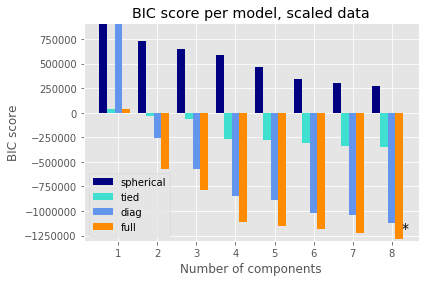

In [16]:
# normalize data and perform GMM component selection
dfn = preprocessing.scale(dff)
bic = GMM.bic_scores(dfn, 8)
plot.features.gmm_bic_scores(bic, title='BIC score per model, scaled data')

In [17]:
# GMM fit (100% of data), components manually selected from plot above
# trying full-6 and spherical-4
clf = GMM.GMM(n_components=4, covariance_type='spherical')
clf.fit(dfn)

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=4, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

Log probs shape: 45741


'Log probs mean: -6.456071145498365'

'Log probs min: -101.89211207413456'

'Log probs max: -1.263270899952998'

1pct percentile: -17


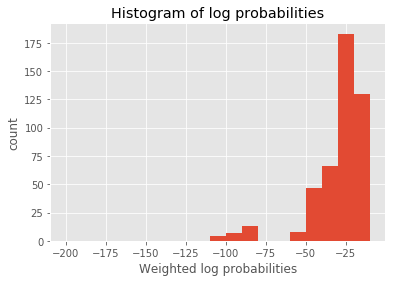

In [19]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned 
# testing set = training set !
log_probs = clf.anomaly_scores(dfn)
print("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
print("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]

binwidth = 10
plt.figure()
plt.hist(anomaly_log_probs, bins=np.arange(-200, max(anomaly_log_probs) + binwidth, binwidth));
plt.title("Histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

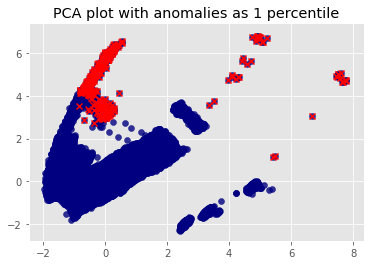

In [20]:
p = PCA.PCA(n_components=2)
pca_data = p.transform(dfn)
p.plot_anomalies(pca_data, idx[0], "PCA plot with anomalies as 1 percentile")

Try to plot it

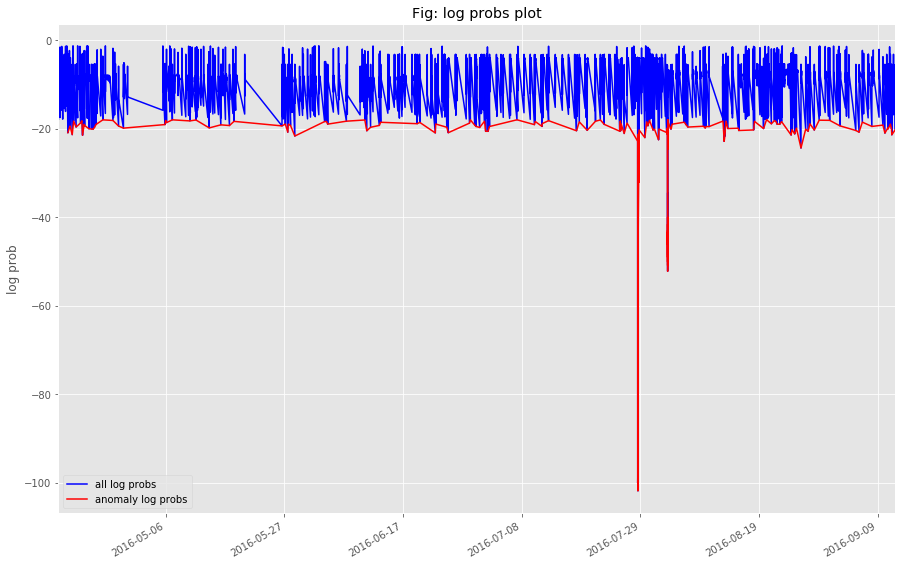

In [21]:
log_probs_df = pd.DataFrame(data=log_probs, index=dff.index)
anomaly_log_probs_df = log_probs_df.iloc[idx[0].tolist()]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df.plot(ax=axes, color='b')
anomaly_log_probs_df.plot(ax=axes, color='r')

axes.legend(["all log probs", "anomaly log probs"])
axes.set_ylabel("log prob")
axes.set_title("Fig: log probs plot")

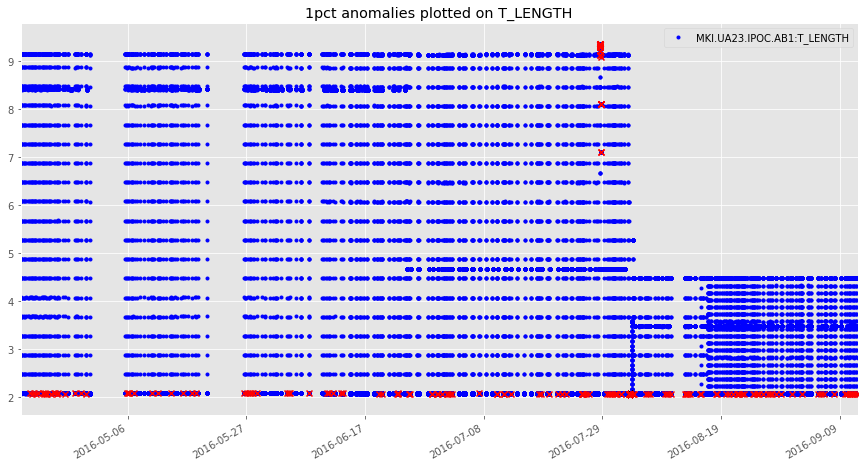

In [25]:
plot.anomalies.anomalies_timeseries(dff, "T_LENGTH", idx[0], "1pct anomalies plotted on T_LENGTH", 'none')

array(['2016-07-28T13:11:13.887000000', '2016-07-28T13:12:35.487000000',
       '2016-07-28T13:13:57.087000000', '2016-07-28T13:26:11.487000000',
       '2016-07-28T13:28:54.687000000', '2016-07-28T13:30:16.287000000',
       '2016-07-28T13:55:25.886000000', '2016-07-28T14:00:11.487000000',
       '2016-07-28T14:01:33.087000000', '2016-07-28T14:08:06.687000000',
       '2016-07-28T14:10:54.687000000'], dtype='datetime64[ns]')

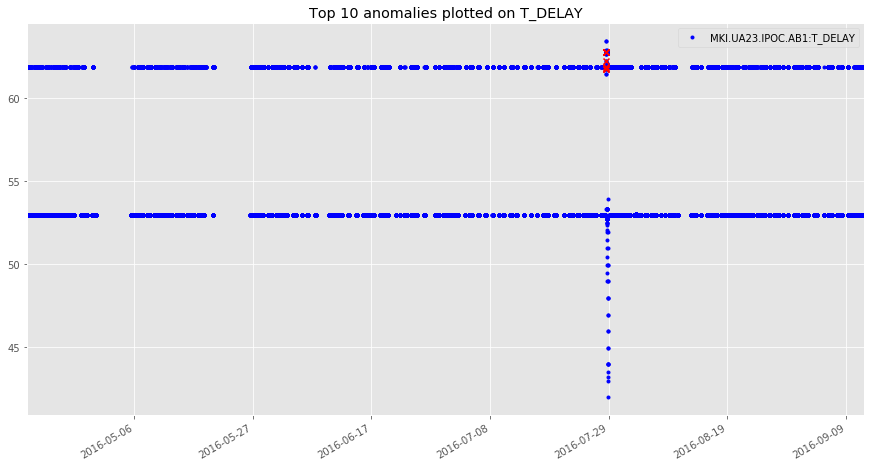

In [28]:
limit = 10
idx2 = np.argpartition(log_probs, limit) #first 20 elements will be the indexes of smallest elements
idx2 = idx2[:limit+1]
anomaly_tstamps = dff.index[idx2].sort_values()
display(anomaly_tstamps.values)

plot.anomalies.anomalies_timeseries(dff, "T_DELAY", idx2, "Top 10 anomalies plotted on T_DELAY", 'none')

## Trying to add e-logbook entries to the same plot.

Fetching data for pattern MKI.ELOGBOOK$ from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


MKI.ELOGBOOK
2016-04-23 04:00:00  {'VALUE': 'MKI8', 'EVENTDATE': '23/04/2016 06:...
2016-04-23 10:15:28  {'VALUE': 'MKI8', 'EVENTDATE': '23/04/2016 12:...
2016-04-24 05:19:36  {'VALUE': 'MKI8', 'EVENTDATE': '24/04/2016 07:...
2016-04-24 12:03:20  {'VALUE': 'MKI8', 'EVENTDATE': '24/04/2016 14:...
2016-04-26 10:00:00  {'VALUE': 'MKI8', 'EVENTDATE': '26/04/2016 12:...

C0            EVENTDATE EVENT_ID      PATH  \
2016-04-23 04:00:00  1  23/04/2016 06:00:00  2098246  LHC.MKI8   
2016-04-23 10:15:28  2  23/04/2016 12:15:28  2098379  LHC.MKI8   
2016-04-24 05:19:36  3  24/04/2016 07:19:36  2098811  LHC.MKI8   
2016-04-24 12:03:20  4  24/04/2016 14:03:20  2098949  LHC.MKI8   
2016-04-26 10:00:00  5  26/04/2016 12:00:00  2100547  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
2016-04-23 04:00:00  Piquet contact me for the MKI8 problem with th...   
2016-04-23 10:15:28  At the same moment as the LBDS XPOC fault, the...   
2016-04-24 05:19:36  CCC LHC calls for MKI8 faulty. Same problem as...   
2016-04-24 12:03:20  CCC calls, again SVM fault for KTC6 rack. I tr...   
2016-04-26 10:00:00  High vacuum in MKI8d-Q5 interconnect during sc...   

                          TAG                   USERNAME VALUE  
2016-04-23 04:00:00     fault  christophe.boucly@cern.ch  MKI8  
2016-04-23 10:15:28     fault                   pvantrap  MKI8  
2016-04-24 05:19:36     fault                   pvantrap  MKI8  
2016-04-24 12:03:20     fault                   pvantrap  MKI8  
2016-04-26 10:00:00  research        mike.barnes@cern.ch  MKI8

df shape: (100, 1)
Piquet contact me for the MKI8 problem with the SVM system and WinCC connection problem

For the KTC 6 in fault, impossible to rearm this fault even with the mask activated.
The piquet hasn't the right to connect and investigate the problem actually and see with him in remote

Apparently the reset fload is stilled at 1 and no unlatch in the software.
I reset the condition and ack the fault
I change the condition and add the OB32 for the integration of the SVM function with a 1s cycle to prevent the n


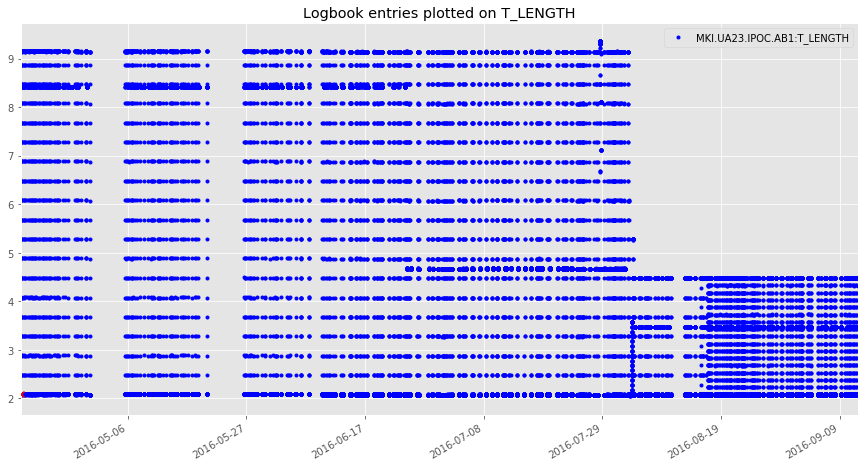

In [48]:
logdf = db.query("MKI.ELOGBOOK$")
logdf2 = db.query_elogbook()

display(logdf.head(), logdf2.head())
print("df shape:", logdf.shape)
print(logdf[logdf.columns[0]].values[0]['SUBSTR_COMMENT_512_'])

# filtering after data start-date 2016-07-01
logged_timestamps = logdf2['2016-07-01':].index
logged_idx = [1]
plot.anomalies.anomalies_timeseries(dff, "T_LENGTH", logged_idx, "Logbook entries plotted on T_LENGTH", 'none')